# Taller Física Computacional 1

Este cuaderno resuelve y explica cada punto del taller: series de Taylor, diferencias finitas y métodos numéricos (Euler, Verlet, RK4).

## 1) Importar librerías y configuración
A continuación importamos NumPy, SymPy y Matplotlib, habilitamos impresión simbólica y definimos utilidades:
- rel_error_pct(exacto, aprox): error relativo porcentual robusto.
- grid_uniform(t0, t1, h): malla uniforme con validación de signo de h.

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple

# Opcional: referencia de SciPy si está disponible
try:
    from scipy.integrate import solve_ivp
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

sp.init_printing(use_latex='mathjax')
plt.style.use('seaborn-v0_8')

# Utilidades

def rel_error_pct(exacto: float, aprox: float) -> float:
    """Error relativo porcentual seguro. Si exacto==0, usa denominador max(|aprox|, eps)."""
    eps = 1e-15
    denom = abs(exacto) if abs(exacto) > eps else max(abs(aprox), eps)
    return 100.0 * abs(aprox - exacto) / denom


def grid_uniform(t0: float, t1: float, h: float) -> np.ndarray:
    """Crea malla uniforme de [t0, t1] con paso h (h puede ser negativo). Valida consistencia de signo.
    Incluye ambos extremos con ajuste del último punto por tolerancia numérica.
    """
    assert h != 0.0, "El paso h no puede ser 0."
    if (t1 - t0) * h < 0:
        raise ValueError("El signo de h no es consistente con la dirección de integración.")
    n_float = (t1 - t0) / h
    n = int(round(n_float))
    if not np.isclose(n_float, n, atol=1e-10):
        # Ajusta t1 para que coincida con un múltiplo entero de h
        t1 = t0 + n * h
    return np.linspace(t0, t1, n + 1)

## 1) Pregunta teórica: propósito principal de una serie de Taylor

Respuesta: b) Aproximar una función complicada mediante un polinomio.

Justificación breve: La serie de Taylor localmente aproxima una función suave alrededor de un punto mediante un polinomio cuyos coeficientes se obtienen de las derivadas en ese punto.

## 2) Serie de Taylor de orden 4 en x=0 para f(x)

f(x) = −0.1 x^4 − 0.15 x^3 − 0.5 x^2 − 0.25 x + 1.2.

Como es un polinomio de grado 4, su expansión de Taylor de orden 4 en x=0 coincide exactamente con f(x) (no hay término de resto de orden > 4). Aun así, verificamos simbólicamente.

In [2]:
# Definición simbólica y verificación de Taylor
x = sp.symbols('x')
f = -sp.Rational(1,10)*x**4 - sp.Rational(15,100)*x**3 - sp.Rational(1,2)*x**2 - sp.Rational(1,4)*x + sp.Rational(12,10)
serie = sp.series(f, x, 0, 5)  # hasta x^4 (orden 5 excluye términos >= x^5)
trunc = sp.series(f, x, 0, 5).removeO()
print("f(x)   =", sp.simplify(f))
print("Serie4 =", trunc)
assert sp.simplify(trunc - f) == 0
print("Verificación: la serie de orden 4 coincide exactamente con f(x)")

f(x)   = -x**4/10 - 3*x**3/20 - x**2/2 - x/4 + 6/5
Serie4 = -x**4/10 - 3*x**3/20 - x**2/2 - x/4 + 6/5
Verificación: la serie de orden 4 coincide exactamente con f(x)


## 3) Diferencias finitas para y = x^2 + cos x en x0=0.4, h=0.1

Calculamos las aproximaciones hacia adelante, hacia atrás y central, y los errores relativos porcentuales frente a la derivada exacta y'(x)=2x - sin x.

In [3]:
# Diferencias finitas y errores
x0 = 0.4
h = 0.1
f = lambda x: x**2 + np.cos(x)
fp_exact = lambda x: 2*x - np.sin(x)

forward = (f(x0 + h) - f(x0)) / h
backward = (f(x0) - f(x0 - h)) / h
central = (f(x0 + h) - f(x0 - h)) / (2*h)

true_val = fp_exact(x0)
err_f = rel_error_pct(true_val, forward)
err_b = rel_error_pct(true_val, backward)
err_c = rel_error_pct(true_val, central)

print(f"y'(x0) exacta = {true_val:.10f}")
print(f"Adelante  = {forward:.10f} | error % = {err_f:.6f}")
print(f"Atrás     = {backward:.10f} | error % = {err_b:.6f}")
print(f"Central   = {central:.10f} | error % = {err_c:.6f}")
print("(Orden esperado: adelante/atrás O(h), central O(h^2))")

y'(x0) exacta = 0.4105816577
Adelante  = 0.4652156789 | error % = 13.306493
Atrás     = 0.3572450488 | error % = 12.990500
Central   = 0.4112303638 | error % = 0.157997
(Orden esperado: adelante/atrás O(h), central O(h^2))


## 4) Pregunta teórica: fórmula iterativa del método de Euler

Respuesta: a) $Y_{n+1} = Y_n + h\,f(X_n, Y_n)$.

Es la fórmula explícita de Euler hacia adelante.

## 5) Método de Euler para y' = cos(2t) + sin(3t), y(0)=2, h=1e-4, 0≤t≤1

Implementamos Euler y comparamos con la solución analítica $y(t)=2+\tfrac{1}{2}\sin(2t)+\tfrac{1}{3}(1-\cos(3t))$.

y(1) num = 3.1180432905
y(1) exact = 3.1179795456
Error máximo (inf) = 6.374e-05
Error RMS (L2)     = 2.719e-05


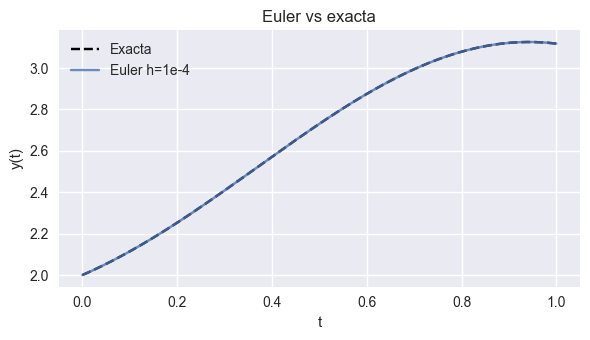

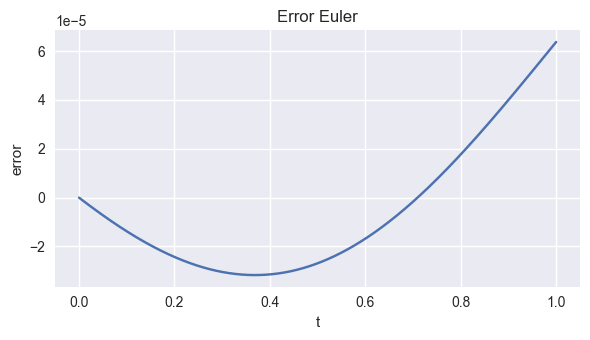

In [4]:
def euler(f: Callable[[float, float], float], t0: float, y0: float, h: float, n: int) -> Tuple[np.ndarray, np.ndarray]:
    t = t0 + h * np.arange(n + 1)
    y = np.empty(n + 1, dtype=float)
    y[0] = y0
    for i in range(n):
        y[i+1] = y[i] + h * f(t[i], y[i])
    return t, y

f = lambda t, y: np.cos(2*t) + np.sin(3*t)

t0, y0, h = 0.0, 2.0, 1e-4
n = int(round((1.0 - t0)/h))
t, y_num = euler(f, t0, y0, h, n)

# Solución analítica
y_exact = 2.0 + 0.5*np.sin(2*t) + (1.0 - np.cos(3*t))/3.0

err_inf = np.max(np.abs(y_num - y_exact))
err_l2 = np.sqrt(np.mean((y_num - y_exact)**2))

print(f"y(1) num = {y_num[-1]:.10f}")
print(f"y(1) exact = {y_exact[-1]:.10f}")
print(f"Error máximo (inf) = {err_inf:.3e}")
print(f"Error RMS (L2)     = {err_l2:.3e}")

plt.figure(figsize=(6,3.5))
plt.plot(t, y_exact, 'k--', label='Exacta')
plt.plot(t, y_num, label='Euler h=1e-4', alpha=0.8)
plt.xlabel('t'); plt.ylabel('y(t)'); plt.legend(); plt.title('Euler vs exacta')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.5))
plt.plot(t, y_num - y_exact)
plt.xlabel('t'); plt.ylabel('error'); plt.title('Error Euler')
plt.tight_layout(); plt.show()

## 6) Caída libre con Verlet: comparación con solución analítica y Euler

Planteamos $\ddot y=-g$, $y(0)=100$ m, $v(0)=0$ m/s, con $g=9.81$ m/s². Integramos hasta impacto y comparamos trayectorias y tiempos de impacto.

Tiempo de impacto analítico ≈ 4.515236 s
Impacto (Verlet) ≈ 4.515234 s | error = 2.762e-06 s
Impacto (Euler)  ≈ 4.520239 s | error = 5.003e-03 s


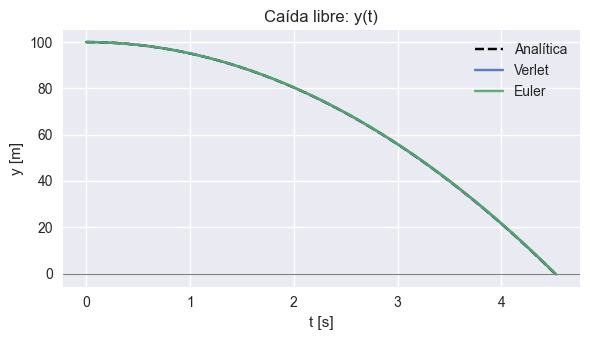

In [5]:
# Integradores: Verlet y Euler para caída libre

def free_fall_verlet(y0=100.0, v0=0.0, g=9.81, h=0.01, tmax=10.0):
    # a = -g constante
    t = [0.0]
    y = [y0]
    # Arranque con ecuación de posición
    y1 = y0 + v0*h - 0.5*g*h*h
    y.append(y1)
    nmax = int(tmax/h)
    for n in range(1, nmax):
        yn1 = 2*y[n] - y[n-1] - g*h*h
        y.append(yn1)
        t.append(n*h)
        if yn1 <= 0.0:
            break
    # alineamos tiempos con y
    t = np.array([i*h for i in range(len(y))])
    y = np.array(y)
    # Interpolación lineal para tiempo de impacto
    if y[-1] > 0:
        t_impact = np.nan
    else:
        t_impact = t[-2] + (0 - y[-2])*(t[-1]-t[-2])/(y[-1]-y[-2])
    return t, y, t_impact


def free_fall_euler(y0=100.0, v0=0.0, g=9.81, h=0.01, tmax=10.0):
    t = [0.0]
    y = [y0]
    v = [v0]
    nmax = int(tmax/h)
    for n in range(nmax):
        v_new = v[-1] - g*h
        y_new = y[-1] + v[-1]*h
        t_new = t[-1] + h
        v.append(v_new)
        y.append(y_new)
        t.append(t_new)
        if y_new <= 0.0:
            break
    t = np.array(t)
    y = np.array(y)
    v = np.array(v)
    if y[-1] > 0:
        t_impact = np.nan
    else:
        t_impact = t[-2] + (0 - y[-2])*(t[-1]-t[-2])/(y[-1]-y[-2])
    return t, y, v, t_impact

# Simulación
h = 0.01
y0, v0, g = 100.0, 0.0, 9.81

# Analítica
t_f = np.sqrt(2*y0/g)

# Verlet
t_vr, y_vr, t_imp_vr = free_fall_verlet(y0, v0, g, h)
# Euler
t_eu, y_eu, v_eu, t_imp_eu = free_fall_euler(y0, v0, g, h)

print(f"Tiempo de impacto analítico ≈ {t_f:.6f} s")
print(f"Impacto (Verlet) ≈ {t_imp_vr:.6f} s | error = {abs(t_imp_vr - t_f):.3e} s")
print(f"Impacto (Euler)  ≈ {t_imp_eu:.6f} s | error = {abs(t_imp_eu - t_f):.3e} s")

T = np.linspace(0, max(t_vr[-1], t_eu[-1], t_f), 1000)
y_exact = y0 + v0*T - 0.5*g*T**2

plt.figure(figsize=(6,3.5))
plt.plot(T, y_exact, 'k--', label='Analítica')
plt.plot(t_vr, y_vr, label='Verlet', alpha=0.9)
plt.plot(t_eu, y_eu, label='Euler', alpha=0.9)
plt.axhline(0, color='gray', lw=0.8)
plt.xlabel('t [s]'); plt.ylabel('y [m]'); plt.legend(); plt.title('Caída libre: y(t)')
plt.tight_layout(); plt.show()

## 7) Pregunta teórica: fórmula general de RK4

Respuesta: c) $y_{n+1} = y_n + \tfrac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)$.

Con $k_1 = f(x_n, y_n)$, $k_2 = f(x_n + h/2, y_n + h k_1/2)$, etc.

## 6) Método RK4 genérico e integración hacia atrás

Implementamos RK4 que soporte paso h negativo y estados escalares o vectoriales.

In [6]:
def rk4(f: Callable[[float, np.ndarray], np.ndarray], t0: float, y0, h: float, n: int):
    y0 = np.array(y0, dtype=float)
    y = np.empty((n+1,) + y0.shape, dtype=float)
    t = t0 + h * np.arange(n + 1)
    y[0] = y0
    for i in range(n):
        ti = t[i]
        yi = y[i]
        k1 = f(ti, yi)
        k2 = f(ti + h/2, yi + h*k1/2)
        k3 = f(ti + h/2, yi + h*k2/2)
        k4 = f(ti + h,   yi + h*k3)
        y[i+1] = yi + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    # Reducir dimensión si era escalar
    if y0.shape == ():
        y = y.reshape(-1)
    return t, y

## 8) Aplicación de RK4 a y' = −2 cos(2t) + sin(y)

Integramos desde t0 = −1 hasta t1 = −2 con N = 10 pasos, de modo que h = (t1 − t0)/N = −0.1. Comparamos contra una referencia de alta precisión si SciPy está disponible.

h = -0.1
t: [-1.  -1.1 -1.2 -1.3 -1.4 -1.5 -1.6 -1.7 -1.8 -1.9 -2. ]
y (RK4): [ 0.         -0.09620176 -0.21394805 -0.34636889 -0.48649764 -0.62752741
 -0.7629577  -0.88664741 -0.99282535 -1.07612089 -1.13166881]
Error máx vs solve_ivp = 2.051e-06


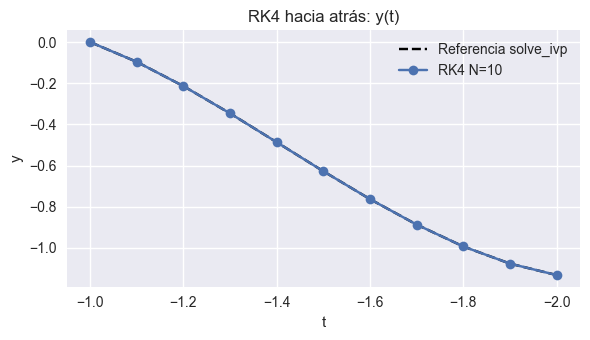

In [7]:
f = lambda t, y: -2*np.cos(2*t) + np.sin(y)

t0, y0 = -1.0, 0.0
t1 = -2.0
N = 10
h = (t1 - t0) / N  # -0.1

# Integración con RK4 hacia atrás
t_rk, y_rk = rk4(f, t0, y0, h, N)

print(f"h = {h}")
print("t:", t_rk)
print("y (RK4):", y_rk)

# Comparación con referencia si SciPy está disponible
if SCIPY_AVAILABLE:
    sol = solve_ivp(lambda t, y: -2*np.cos(2*t) + np.sin(y), (t0, t1), [y0], rtol=1e-10, atol=1e-12, method='DOP853', dense_output=True)
    t_ref = t_rk
    y_ref = sol.sol(t_ref)[0]
    err = np.abs(y_rk - y_ref)
    print(f"Error máx vs solve_ivp = {err.max():.3e}")
    plt.figure(figsize=(6,3.5))
    plt.plot(t_ref, y_ref, 'k--', label='Referencia solve_ivp')
    plt.plot(t_rk, y_rk, 'o-', label='RK4 N=10')
    plt.gca().invert_xaxis()  # para ver -1 -> -2
    plt.xlabel('t'); plt.ylabel('y'); plt.title('RK4 hacia atrás: y(t)')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    plt.figure(figsize=(6,3.5))
    plt.plot(t_rk, y_rk, 'o-')
    plt.gca().invert_xaxis()
    plt.xlabel('t'); plt.ylabel('y'); plt.title('RK4 hacia atrás: y(t)')
    plt.tight_layout(); plt.show()